In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pickle

#sklearn 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# READING DATA

In [4]:
#Reading the dleaned dataset
file_path = '../data/data.csv'

df = pd.read_csv(file_path)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3894 entries, 0 to 3893
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             3894 non-null   object 
 1   Length          3894 non-null   float64
 2   Diameter        3894 non-null   float64
 3   Height          3894 non-null   float64
 4   Weight          3893 non-null   float64
 5   Shucked Weight  3894 non-null   float64
 6   Viscera Weight  3893 non-null   float64
 7   Shell Weight    3893 non-null   float64
 8   Age             3894 non-null   float64
dtypes: float64(8), object(1)
memory usage: 273.9+ KB


# DATA EXPLORATION

In [ ]:
# Show the basic statistics of the numerical features
df.describe()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
count,3894.000000,3894.000000,3894.000000,3893.000000,3894.000000,3893.000000,3893.000000,3894.000000
mean,1.311415,1.020984,0.349403,23.567275,10.210581,5.136546,6.795844,9.954802
std,0.300470,0.248266,0.104978,13.891201,6.277724,3.104133,3.943392,3.220553
min,0.187500,0.137500,0.000000,0.056699,0.028349,0.014175,0.042524,1.000000
25%,1.125000,0.875000,0.287500,12.672227,5.343881,2.664853,3.713785,8.000000
50%,1.362500,1.062500,0.362500,22.792998,9.546694,4.861939,6.662132,10.000000
75%,1.537500,1.200000,0.412500,32.786197,14.273973,7.200773,9.355335,11.000000
max,2.037500,1.625000,2.825000,80.101512,42.184056,21.545620,28.491248,29.000000


There is an issue for Height feature, it should not be 0

There is one missing value

Skewness: 1.105
Kurtosis: 2.337
count    3894.000000
mean        9.954802
std         3.220553
min         1.000000
25%         8.000000
50%        10.000000
75%        11.000000
max        29.000000
Name: Age, dtype: float64


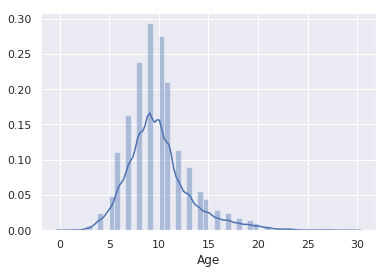

In [207]:
# checking the target variable: Age

print("Skewness: %.3f" % df['Age'].skew())
print("Kurtosis: %.3f" % df['Age'].kurt())

print(df['Age'].describe())
sns.distplot(df['Age'])

The target variable is ok, a bit skewed to the right

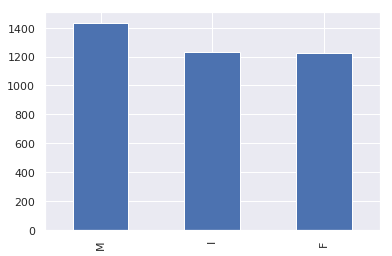

In [208]:
# Categorical feature:see any inbalance
df['Sex'].value_counts().plot.bar()

Seems pretty balance

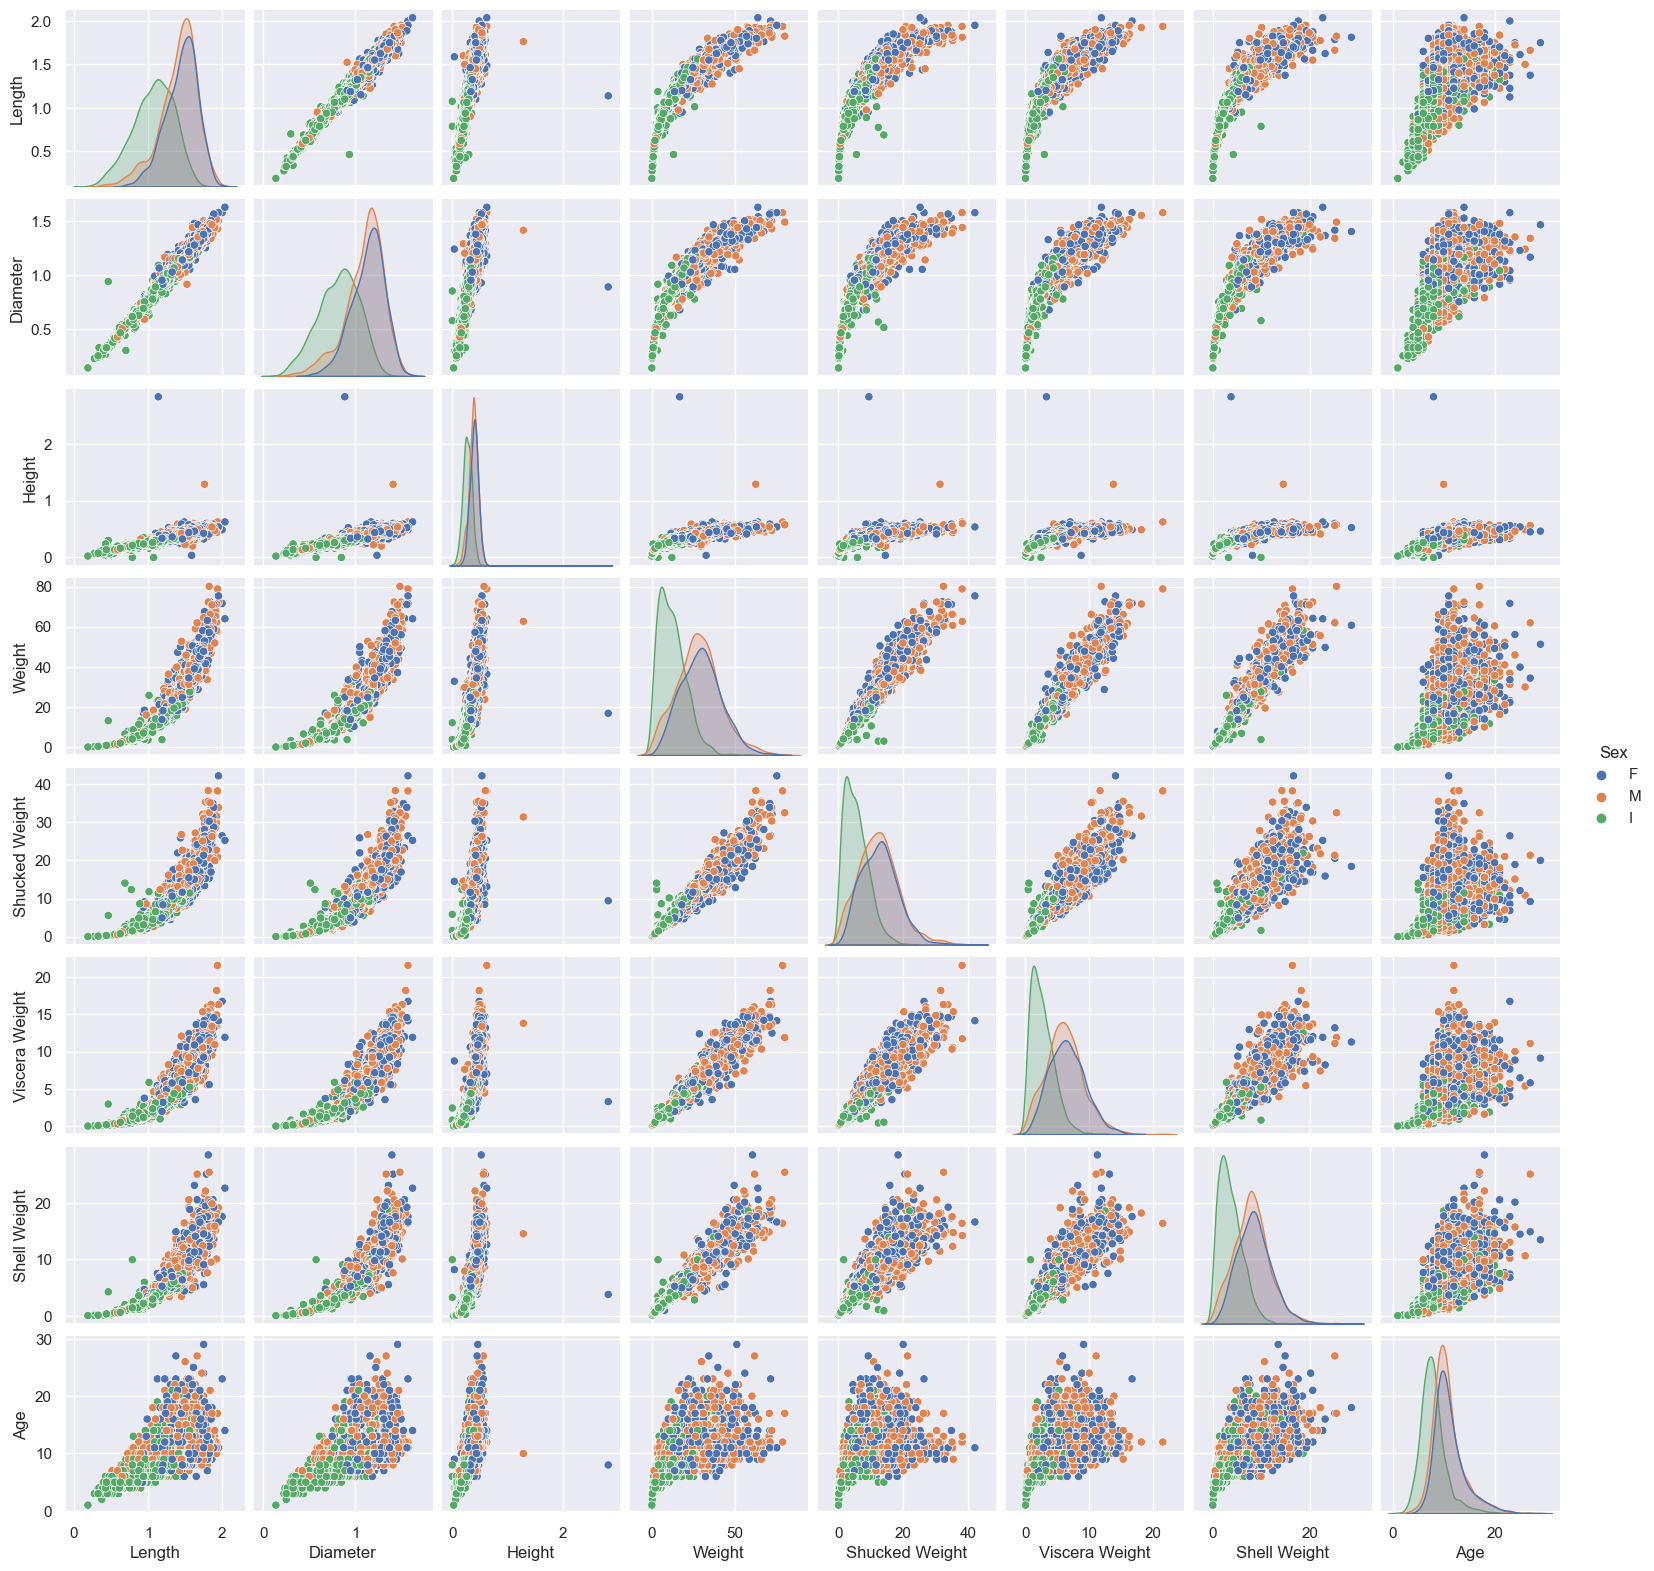

In [6]:
# Pair plot grouped by the only categorial variable
sns.pairplot(df, hue = 'Sex', height = 2)

The crab would be smaller and younger if the sex is I

It seems most of the features are highly correlated with others.

We can see there are several outliers in the data( Height), we should remove them

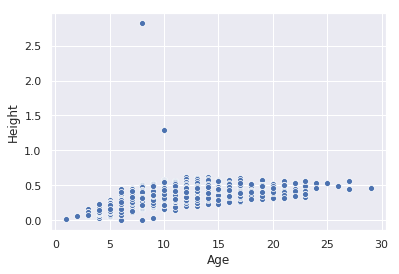

In [212]:
#From the scatter plot: it is better to remove Height > 1

sns.scatterplot(df['Age'],df['Height'])

#Data cleaning

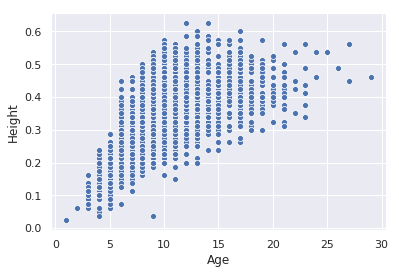

In [213]:
#drop outliers for Height <=0 and >1

df = df.query('Height >0 & Height <1')

#check if it look better
sns.scatterplot(df['Age'],df['Height'])

In [214]:
#as there is only one missing record, we can just drop it
df.dropna(inplace = True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [ ]:

#One hot encode the categorial data
Sex_cat = pd.get_dummies(df['Sex'], prefix = 'Sex')

df = pd.concat([df,Sex_cat],axis = 1)
df.drop('Sex',axis = 1, inplace = True)

In [216]:
df.head()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Sex_F,Sex_I,Sex_M
0,1.4375,1.1750,0.4125,24.635715,12.332033,5.584852,6.747181,9.0,1,0,0
1,0.8875,0.6500,0.2125,5.400580,2.296310,1.374951,1.559222,6.0,0,0,1
2,1.0375,0.7750,0.2500,7.952035,3.231843,1.601747,2.764076,6.0,0,1,0
3,1.1750,0.8875,0.2500,13.480187,4.748541,2.282135,5.244657,10.0,1,0,0
4,0.8875,0.6625,0.2125,6.903103,3.458639,1.488349,1.700970,6.0,0,1,0


#Features Engineering

In [ ]:
''' 
The intuitive thinking would be the larger the volume the older it is so
we can create a feature called size which is Length * Diameter * Height
'''

df['Size'] = df['Length']*df['Diameter']*df['Height']

'''
We all have experienced that we eat a large crab but just little meat inside
so lets create three features called density which is weight/ size
density_shucked as scucked weight/ size
density_viscera as Viscera Weight/size
'''

df['Density'] = df['Weight']/df['Size']
df['Density_shucked'] = df['Shucked Weight']/df['Size']
df['Density_viscera'] = df['Viscera Weight'] /df['Size']

# lets see how much its weight without the shell
df['Weight_no_Shell'] = df['Weight'] - df['Shell Weight']

#Also the density without the shell
df['Density_no_shell'] = df['Weight_no_Shell']/df['Size']

In [218]:
df.describe()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Sex_F,Sex_I,Sex_M,Size,Density,Density_shucked,Density_viscera,Weight_no_Shell,Density_no_shell
count,3889.000000,3889.000000,3889.000000,3889.000000,3889.000000,3889.000000,3889.000000,3889.000000,3889.000000,3889.000000,3889.000000,3889.000000,3889.000000,3889.000000,3889.000000,3889.000000,3889.000000
mean,1.311430,1.020985,0.348676,23.566978,10.205423,5.136603,6.794735,9.956801,0.314734,0.316534,0.368732,0.543229,44.618646,19.319918,9.746920,16.772243,31.532229
std,0.300344,0.248154,0.095736,13.878951,6.267387,3.101406,3.942452,3.221693,0.464470,0.465184,0.482523,0.325657,9.534930,6.513708,2.763640,10.176381,7.657793
min,0.187500,0.137500,0.025000,0.056699,0.028349,0.014175,0.042524,1.000000,0.000000,0.000000,0.000000,0.000645,13.761465,7.753709,3.716063,0.014175,0.889524
25%,1.125000,0.875000,0.287500,12.686401,5.343881,2.679028,3.713785,8.000000,0.000000,0.000000,0.000000,0.284883,40.319289,16.389993,8.408286,8.788345,27.822726
50%,1.362500,1.062500,0.362500,22.792998,9.553781,4.861939,6.662132,10.000000,0.000000,0.000000,0.000000,0.515625,43.692560,18.724401,9.475175,15.918244,30.859467
75%,1.537500,1.200000,0.412500,32.786197,14.273973,7.200773,9.355335,11.000000,1.000000,1.000000,1.000000,0.764285,47.578884,21.404843,10.676885,23.558435,34.250351
max,2.037500,1.625000,0.625000,80.101512,42.184056,21.545620,28.491248,29.000000,1.000000,1.000000,1.000000,2.069336,445.041829,227.586230,118.523894,62.411424,334.021883


#Split train and test set
Split the data into training and testing dataset for the model evaluation

In [ ]:
#20% for testing
y = df['Age']
X = df.drop('Age',axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size = 0.2, 
                                                    random_state = 123
                                                   )

#Modelling

**First trial: random forest regressor**

In [ ]:
rf_grid_param = {
    'n_estimators': [200,300],
    'max_depth': [5,10,15,None],
    'min_samples_split': [0.01,0.02],
    'min_samples_leaf': [1, 2, 4]
}

rf_regressor = RandomForestRegressor(random_state= 123)

In [ ]:
rf_GS = GridSearchCV(estimator=rf_regressor,
                     param_grid=rf_grid_param,
                     scoring= ['r2','neg_mean_squared_error','neg_mean_absolute_error'],
                     refit = 'neg_mean_squared_error',
                     cv = 5,
                     n_jobs = -1,
                     verbose = 2
                     )

In [72]:
rf_GS.fit(X_train,y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  9.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=123,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, None],
  

In [73]:
print(rf_GS.best_params_)
print(rf_GS.best_score_)

{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 0.01, 'n_estimators': 300}
-4.701328136293398


**Second try: XGBoost**

In [ ]:
xgb_grid_param = {
    'n_estimators': [400,500],
    'max_depth': [5,10],
    'learning_rate': [0.01,0.02],
    'subsample': [0.9,1],
    'min_samples_leaf': [1, 2, 4]
}

xgb_regressor = xgb.XGBRegressor(eval_metric = 'rmse',n_jobs= -1,random_state=123)

In [ ]:
xgb_GS = GridSearchCV(estimator=xgb_regressor,
                     param_grid=xgb_grid_param,
                     scoring= ['r2','neg_mean_squared_error','neg_mean_absolute_error'],
                     refit = 'neg_mean_squared_error',
                     cv = 5,
                     n_jobs = -1,
                     verbose = 8
                     )

In [84]:
xgb_GS.fit(X_train,y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   54.7s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  9.1min finished
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:21:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, eval_metric='rmse',
                                    gamma=0, importance_type='gain',
                                    learning_rate=0.1, max_delta_step=0,
                                    max_depth=3, min_child_weight=1,
                                    missing=None, n_estimators=100, n_jobs=-1,
                                    nthread=None, objective='reg:lin...
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.02], 'max_depth': [5, 10],
                         'min_samples_leaf': [1, 2, 4],
                         'n_estimators': [400, 500

In [85]:
print(xgb_GS.best_score_)
print(xgb_GS.best_params_)

-4.652817813756927
{'learning_rate': 0.01, 'max_depth': 5, 'min_samples_leaf': 1, 'n_estimators': 500, 'subsample': 0.9}


# Testing
tsting the result using final model

In [220]:
best_xgb = xgb.XGBRegressor(**xgb_GS.best_params_, eval_metric = 'rmse',n_jobs= -1, objective='reg:squarederror')
best_xgb.fit(X_train,y_train)
y_pred_xgb = best_xgb.predict(X_test)

best_rf = RandomForestRegressor(**rf_GS.best_params_)
best_rf.fit(X_train,y_train)
y_pred_rf = best_rf.predict(X_test)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [248]:
print ('Result using XGBoost Regressor:')
print("MSE: %.3f" % mean_squared_error(y_test,y_pred_xgb))
print("MSE: %.3f" % np.sqrt(mean_squared_error(y_test,y_pred_xgb)))
print("MAE: %.3f" % mean_absolute_error(y_test,y_pred_xgb))
print("R2: %.3f" % r2_score(y_test,y_pred_xgb))

print ('Result using Random Forest Regressor:')
print("MSE: %.3f" % mean_squared_error(y_test,y_pred_rf))
print("MSE: %.3f" % np.sqrt(mean_squared_error(y_test,y_pred_rf)))
print("MAE: %.3f" % mean_absolute_error(y_test,y_pred_rf))
print("R2: %.3f" % r2_score(y_test,y_pred_rf))



Result using XGBoost Regressor:
MSE: 4.261
MSE: 2.064
MAE: 1.437
R2: 0.565
Result using Random Forest Regressor:
MSE: 4.289
MSE: 2.071
MAE: 1.469
R2: 0.563


**Save the best model for the program**

In [ ]:
pickle.dump(best_xgb, open('./best_xgb.dat', 'wb'))

**Checking ather stats**

The summary stats of actual data: 
 count    778.000000
mean      10.044987
std        3.133541
min        4.000000
25%        8.000000
50%       10.000000
75%       11.000000
max       23.000000
Name: Age, dtype: float64

The summary stats of predicted data: 
 count    778.000000
mean       9.980339
std        2.393686
min        3.022227
25%        8.506512
50%        9.975065
75%       11.280349
max       19.244614
dtype: float64


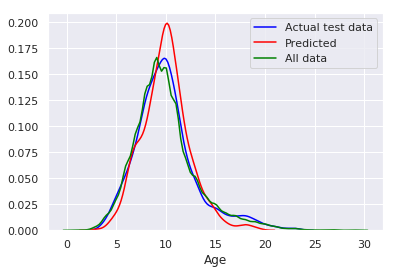

In [235]:
sns.distplot(y_test,color = 'blue',hist = False, label = 'Actual test data')
sns.distplot(y_pred, color = 'red',hist = False,label = 'Predicted')
sns.distplot(df['Age'],color = 'green',hist = False,label = 'All data')

print('The summary stats of actual data: \n',y_test.describe())

print('\nThe summary stats of predicted data: \n' ,pd.Series(y_pred).describe())

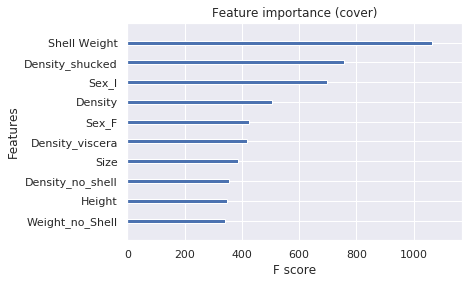

In [169]:
# find out which features are the most important

xgb.plot_importance(best_xgb,importance_type = 'cover',show_values= False ,title = 'Feature importance (cover)',max_num_features= 10)

**As the Shell Weight is the most important feature, lets see how it is distributed across age**

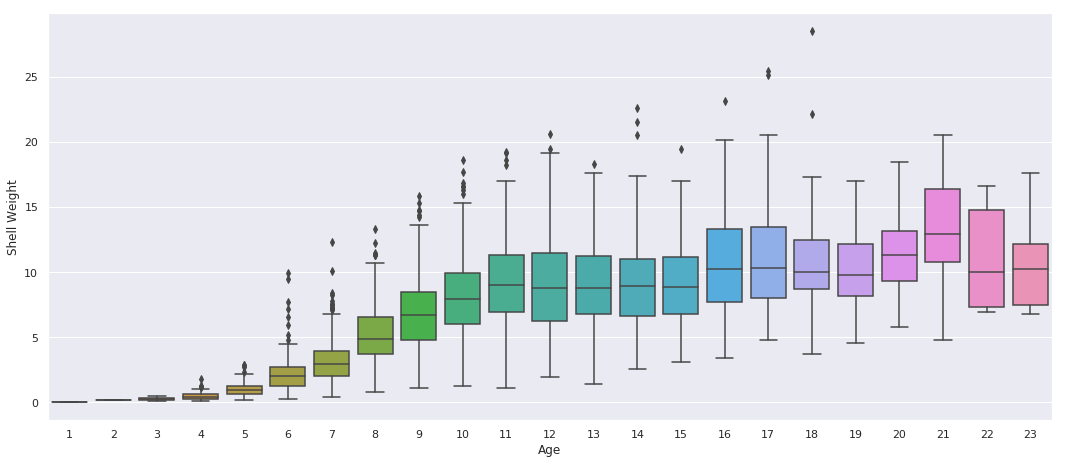

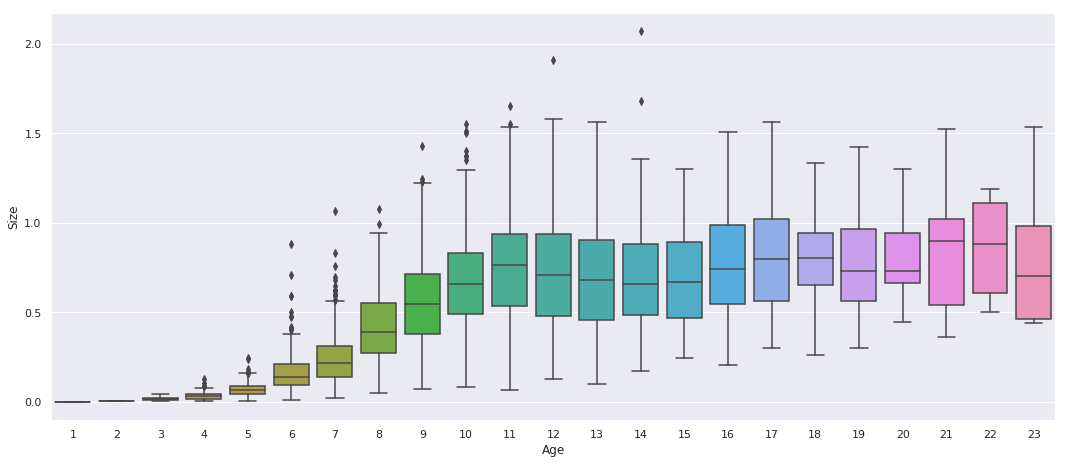

In [245]:
df['Age'] = df['Age'].astype(int)
fig, ax = plt.subplots(figsize=[18,7.5])
sns.boxplot( y = 'Shell Weight', x = 'Age',ax= ax, data = df.query('Age < 24'))
fig, ax2 = plt.subplots(figsize=[18,7.5])
sns.boxplot( y = 'Size', x = 'Age',ax= ax2, data = df.query('Age < 24'))

We can see the Shell weight and the size are about the same after age of 11